# Matrix Multiplication

This notebook describes how to write a matrix multiplication (matmul) algorithm in Mojo. We will start with a pure Python implementation, transition to a naive implementation that is essentially a copy of the Python one, then add types, then continue the optimizations by vectorizing, tiling, and parallelizing the implementation.

First, let's define matrix multiplication. Given two dense matrices $A$ and $B$ of dimensions $M\times K$ and $K\times N$ respectively, we want to compute their dot product $C = A . B$ (also known as matmul). The dot product $C += A . B$ is defined by

$$C_{i,j} += \sum_{k \in [0 \cdots K)} A_{i,k} B_{k,j}$$

The format of this demo is to start with an implementation which is identical to that of Python (effectively renaming the file extension), then look at how adding types to the implementation helps performance before extending the implementation by leveraging the vectorization and parallelization capabilities available on modern hardware. Throughout the execution, we report the GFlops achieved.

## Python Implementation

Let's first implement matmul in Python directly from the definition.

In [1]:
%python
def matmul_python(C, A, B):
    for m in range(C.rows):
        for n in range(C.cols):
            for k in range(A.cols):
                C[m, n] += A[m, k] * B[k, n]

Let's benchmark our implementation using 128 by 128 square matrices and report the achieved GFLops.

In [2]:
%python
import numpy as np
from timeit import timeit

class Matrix:
    def __init__(self, value, rows, cols):
        self.value = value
        self.rows = rows
        self.cols = cols
        
    def __getitem__(self, idxs):
        return self.value[idxs[0]][idxs[1]]
    
    def __setitem__(self, idxs, value):
        self.value[idxs[0]][idxs[1]] = value

def benchmark_matmul_python(M, N, K):
    A = Matrix(list(np.random.rand(M, K)), M, K)
    B = Matrix(list(np.random.rand(K, N)), K, N)
    C = Matrix(list(np.zeros((M, N))), M, N)
    secs = timeit(lambda: matmul_python(C, A, B), number=2)/2
    print(((2*M*N*K)/secs) / 1e9, "GFLOP/s")

In [3]:
# %python # TODO: delete this once we switch to REPL in notebook testing (#12719).
benchmark_matmul_python(128, 128, 128)

0.005480328057626661 GFLOP/s


## Importing the Python implementation to Mojo

Using Mojo is as simple as Python. First, let's include that modules from the Mojo stdlib that we are going to use:

In [4]:
from Benchmark import Benchmark
from DType import DType
from IO import print, _printf, _put_kgen_scalar
from Intrinsics import strided_load
from List import VariadicList, VariadicListMem
from Math import div_ceil
from Memory import memset_zero
from Object import object, Attr
from Pointer import DTypePointer
from Random import rand, random_f64
from Range import range
from SIMD import SIMD, F64, F32
from TargetInfo import dtype_sizeof
from Complex import ComplexSIMD as ComplexGenericSIMD

alias python_gflops = F64(0.005480328057626661)

Then, we can copy and paste our Python code. Mojo is a superset of Python, so the same Python code will run as Mojo code

In [5]:
# This exactly the same Python implementation, 
# but is infact Mojo code!
def matmul_untyped(C, A, B):
    for m in range(C.rows):
        for n in range(C.cols):
            for k in range(A.cols):
                C[m, n] += A[m, k] * B[k, n]

We can then benchmark the implementation. As before we use a 128 by 128 matrix

In [6]:
def matrix_getitem(self, i) -> object:
    return self.value[i]


def matrix_setitem(self, i, value) -> object:
    self.value[i] = value
    return None


def matrix_append(self, value) -> object:
    self.value.append(value)
    return None


def matrix_init(rows: Int, cols: Int) -> object:
    value = object([])
    let getitem: object = __mlir_op.`kgen.addressof`[ _type : object.binary_function, callee:matrix_getitem, paramDecls : __mlir_attr.`#kgen<param.decls[]>`, ]()
    let setitem: object = __mlir_op.`kgen.addressof`[ _type : object.ternary_function, callee:matrix_setitem, paramDecls : __mlir_attr.`#kgen<param.decls[]>`, ]()
    let append: object = __mlir_op.`kgen.addressof`[ _type : object.binary_function, callee:matrix_append, paramDecls : __mlir_attr.`#kgen<param.decls[]>`, ]()
    return object(
        Attr("value", value), Attr("__getitem__", getitem), Attr("__setitem__", setitem), 
        Attr("rows", rows), Attr("cols", cols), Attr("append", append),
    )

def benchmark_matmul_untyped(M: Int, N: Int, K: Int):
    C = matrix_init(M, N)
    A = matrix_init(M, K)
    B = matrix_init(K, N)
    for i in range(M):
        c = object([])
        b = object([])
        a = object([])
        for j in range(N):
            c.append(0.0)
            b.append(random_f64(-5, 5))
            a.append(random_f64(-5, 5))
        C.append(c)
        B.append(b)
        A.append(a)

    fn test_fn():
        try:
            matmul_untyped(C, A, B)
        except:
            pass

    let secs = F64(Benchmark().run[test_fn]()) / 1_000_000_000
    let gflops = ((2*M*N*K)/secs) / 1e9
    _put_kgen_scalar[DType.f64](gflops.value)
    _printf(" GFLOP/s, a ")
    let speedup : F64 = gflops / python_gflops
    _printf("%0.2f", speedup.value)
    print("x speedup over Python")

In [7]:
benchmark_matmul_untyped(128, 128, 128)

0.047082 GFLOP/s, a 8.59x speedup over Python


Note the huge speedup with no effort that we have gotten.

## Adding types to the Python implementation

The above program, while achieving better performance than Python, is still not the best we can get from Mojo. If we tell Mojo the types of the inputs, it can optimize much of the code away and reduce dispatching costs (unlike Python, which only uses types for type checking, Mojo exploits type info for performance optimizations as well).

To do that, let's first define a `Matrix` struct. The `Matrix` struct contains a data pointer along with size fields. While the `Matrix` struct can be parametrized on any data type, here we set the data type to be f32 for conciseness.

In [8]:
struct Matrix:
    var data: DTypePointer[DType.f32]
    var rows: Int
    var cols: Int

    fn __init__(self&, rows: Int, cols: Int):
        self.data = DTypePointer[DType.f32].alloc(rows * cols)
        rand(self.data, rows*cols)
        self.rows = rows
        self.cols = cols

    fn __del___(owned self):
        self.data.free()

    fn zero(self&):
        memset_zero(self.data, self.rows * self.cols * dtype_sizeof[DType.f32]())

    @always_inline
    fn __getitem__(self, y: Int, x: Int) -> F32:
        return self.load[1](y, x)

    @always_inline
    fn load[nelts:Int](self, y: Int, x: Int) -> SIMD[DType.f32, nelts]:
        return self.data.simd_load[nelts](y * self.cols + x)

    @always_inline
    fn load_tr[nelts:Int](self, y: Int, x: Int) -> SIMD[DType.f32, nelts]:
        # Perform a transposed simd load. 
        # return strided_load[nelts,DType.f32](self.data + x* dtype_sizeof[DType.f32](), self.cols)
        var res = SIMD[DType.f32, nelts]()
        res[0] = self[y + 0, x]
        res[1] = self[y + 1, x]
        res[2] = self[y + 2, x]
        res[3] = self[y + 3, x]
        res[4] = self[y + 4, x]
        res[5] = self[y + 5, x]
        res[6] = self[y + 6, x]
        res[7] = self[y + 7, x]
        return res

    @always_inline
    fn __setitem__(self, y: Int, x: Int, val: F32):
        return self.store[1](y, x, val)

    @always_inline
    fn store[nelts:Int](self, y: Int, x: Int, val: SIMD[DType.f32, nelts]):
        var data = self.data
        data.simd_store[nelts](y * self.cols + x, val)

    def to_numpy(self) -> PythonObject:
        let np = Python.import_module("numpy")
        var numpy_array = np.zeros((self.cols, self.rows), np.uint32)
        for x in range(self.cols):
            for y in range(self.rows):
                numpy_array.itemset((y, x), self[x, y])
        return numpy_array

> Note that we implement `getitem` and `setitem` in terms of `load` and `store`. For the naive implementation of matmul it does not make a difference, but we will utilize this later in a more optimized vectorized version of matmul. We are also defining a `load_tr`, which loads a vector from the columns specified at the offset.

With the above `Matrix` type we can effectively copy and paste the Python implementation and just add type annotations:

In [9]:
# Note that C, A, and B have types.
def matmul_naive(C: Matrix, A: Matrix, B: Matrix):
    for m in range(C.rows):
        for n in range(C.cols):
            for k in range(A.cols):
                C[m, n] += A[m, k] * B[k, n]

We are going to benchmark the implementations as we improve, so let's write a helper function that will do that for us: 

In [10]:
@always_inline
def benchmark[func : __mlir_type[
    `!kgen.signature<<>(`,
    `!pop.pointer<`, Matrix,`>`, # C
    ` borrow_in_mem,`,
    `!pop.pointer<`, Matrix,`>`, # A
    ` borrow_in_mem,`,
    `!pop.pointer<`, Matrix,`>`, # B
    ` borrow_in_mem) throws -> `,
    `!pop.variant<`, Error, `,`, NoneType, `>`,
    `>`,
  ]](M : Int, N : Int, K : Int):
    var C = Matrix(M, N)
    C.zero()
    var A = Matrix(M, K)
    var B = Matrix(K, N)

    # func(C, A, B)
    # print(C[10,4])

    @always_inline
    fn test_fn():
        try:
            func(C, A, B)
        except:
            pass

    let secs = F64(Benchmark().run[test_fn]()) / 1_000_000_000
    let gflops = ((2*M*N*K)/secs) / 1e9
    _put_kgen_scalar[DType.f64](gflops.value)
    _printf(" GFLOP/s, a ")
    let speedup : F64 = gflops / python_gflops
    _printf("%0.2f", speedup.value)
    print("x speedup over Python")


Benchmarking shows significant speedups. We increase the size of the matrix to 512 by 512, since Mojo is much faster than Python.

In [11]:
benchmark[matmul_naive](512, 512, 512)

1.702316 GFLOP/s, a 310.62x speedup over Python


Adding type annotations gives a huge improvement compared to the original untyped version.

## Vectorizing the inner most loop

We can do better than the above implementation by utilizing the vector instructions. Assuming a vector width of 8, we can modify the code to leverage SIMD instructions:

In [12]:
# Mojo has SIMD vector types, we can vectorize the Matmul code as follows.
alias nelts = 8 # The SIMD vector width.
def matmul_vectorized_0(C: Matrix, A: Matrix, B: Matrix):
    for m in range(C.rows):
        for n in range(C.cols):
            var tmp = SIMD[DType.f32, nelts]()
            for kv in range(0, A.cols, nelts):
                tmp += A.load[nelts](m,kv) * B.load_tr[nelts](kv,n)
            C[m,n] += tmp.reduce_add()
        
            # Handle remaining elements with scalars.
            for k in range(nelts*(A.cols//nelts), A.cols):
                C[m,n] += A[m,k] * B[k,n]

We can benchmark the above implementation. Note that many compilers can detect naive loops and perform optimizations on them. Mojo, however, allows you to be explicit and precisely control what optimizations are applied.

In [13]:
benchmark[matmul_vectorized_0](512, 512, 512)

3.136114 GFLOP/s, a 572.25x speedup over Python


Vectorization is a common optimization, and Mojo provides a higher-order function that performs vectorization for you. The `vectorize` function takes a vector width and a function which is parameteric on the vector width and is going to be evaluated in a vectorized manner.

In [14]:
# Simplify the code by using the builtin vectorize function
from Functional import vectorize
def matmul_vectorized_1(C: Matrix, A: Matrix, B: Matrix):
    for m in range(C.rows):
        for n in range(C.cols):
            fn dot[nelts : Int](k : Int):
                C[m,n] += (A.load[nelts](m,k) * B.load_tr[nelts](k,n)).reduce_add()
            vectorize[nelts, dot](A.cols)

There is only a slight difference in terms of performance between the two implementations:

In [15]:
benchmark[matmul_vectorized_1](512, 512, 512)

3.125112 GFLOP/s, a 570.27x speedup over Python


## Parallelizing Matmul

To get the best performance from modern processors, one has to utilize the multiple cores they have. With Mojo it can be easily achieved with `parallelize` function.

Let's modify our matmul implementation and make it multi-threaded (for simplicity, we only `parallelize` on the M dimension):

In [16]:
# Parallelize the code by using the builtin parallelize function
from Functional import parallelize
def matmul_parallelized(C: Matrix, A: Matrix, B: Matrix):
    fn calc_row(m: Int):
        for n in range(C.cols):
            fn dot[nelts : Int](k : Int):
                C[m,n] += (A.load[nelts](m,k) * B.load_tr[nelts](k,n)).reduce_add()
            vectorize[nelts, dot](A.cols)
        
    parallelize[calc_row](C.rows)

We can benchmark the parallel matmul implementation. Again, we increase the size of the matrix to 1024 by 1024, since this implementation is much faster than the single-threaded version.

In [17]:
benchmark[matmul_parallelized](1024, 1024, 1024)

11.388119 GFLOP/s, a 2078.00x speedup over Python


## Tiling Matmul

Tiling is an optimization performed for matmul to increase cache locality. The idea is to keep sub-matrices resident in the cache and increase the reuse. The tile function itself can be written in Mojo as:

In [18]:
from Functional import Static2DTileUnitFunc as Tile2DFunc

In [19]:
# Perform 2D tiling on the iteration space defined by end_x and end_y.
fn tile[tiled_fn: Tile2DFunc, tile_x: Int, tile_y: Int](end_x: Int, end_y: Int):
    # Note: this assumes that ends are multiples of the tiles.
    for y in range(0, end_y, tile_y):
        for x in range(0, end_x, tile_x):
            tiled_fn[tile_x, tile_y](x, y)

The above will perform 2 dimensional tiling over a 2D iteration space defined to be between $([0, end_x], [0, end_y])$. Once we define it above, we can use it within our matmul kernel. For simplicity we choose `16` as the tile height and since we also want to vectorize we use `16 * nelts` as the tile width (since we vectorize on the columns).

In [20]:
# Use the above tile function to perform tiled matmul.
def matmul_tiled_parallelized(C: Matrix, A: Matrix, B: Matrix):
    fn calc_row(m: Int):
        fn calc_tile[tile_x: Int, tile_y: Int](x: Int, y: Int):
            for n in range(y, y + tile_y):
                fn dot[nelts: Int](k: Int):
                    C[m,n] += (A.load[nelts](m,k+x) * B.load_tr[nelts](k+x,n)).reduce_add()
                vectorize[nelts, dot](tile_x)
        
        # We hardcode the tile factor to be 16.
        alias tile_size = 16
        tile[calc_tile, nelts * tile_size, tile_size](C.cols, A.cols)

    parallelize[calc_row](C.rows)

Again, we can benchmark the tiled parallel matmul implementation:

In [21]:
benchmark[matmul_tiled_parallelized](1024, 1024, 1024)

11.896004 GFLOP/s, a 2170.67x speedup over Python


One source of overhead in the above implementation is the fact that the we are not unrolling the loops introduced by vectorize of the dot function. We can do that via the `vectorize_unroll` higher-order function in Mojo:

In [22]:
# Unroll the vectorized loop by a constant factor.
from Functional import vectorize_unroll
def matmul_tiled_unrolled_parallelized(C: Matrix, A: Matrix, B: Matrix):
    fn calc_row(m: Int):
        fn calc_tile[tile_x: Int, tile_y: Int](x: Int, y: Int):
            for n in range(y, y + tile_y):
                fn dot[nelts : Int](k : Int):
                    C[m,n] += (A.load[nelts](m,k+x) * B.load_tr[nelts](k+x,y)).reduce_add()
            
                # Vectorize by nelts and unroll by tile_x/nelts
                # Here unroll factor is 16/8 = 2
                vectorize_unroll[nelts, tile_x//nelts, dot](tile_x)

        alias tile_size = 16
        tile[calc_tile, nelts*tile_size, tile_size](A.cols, C.cols)
      
    parallelize[calc_row](C.rows)

Again, we can benchmark the new tiled parallel matmul implementation with unrolled and vectorized inner loop:

In [23]:
benchmark[matmul_tiled_unrolled_parallelized](1024, 1024, 1024)

12.243320 GFLOP/s, a 2234.05x speedup over Python


## Searching for the `tile_factor`

In [24]:
from Autotune import autotune, search
from Time import now
from Pointer import Pointer

alias matmul_fn_type = __mlir_type[
    `( `,
    Pointer[Matrix].pointer_type,
    `, `,
    Pointer[Matrix].pointer_type,
    `, `,
    Pointer[Matrix].pointer_type,
    `) -> `, NoneType
]
alias matmul_fn_sig_type = __mlir_type[
    `!kgen.signature<<>(`,
    `!pop.pointer<`, Matrix,`>`, # C
    ` borrow_in_mem,`,
    `!pop.pointer<`, Matrix,`>`, # A
    ` borrow_in_mem,`,
    `!pop.pointer<`, Matrix,`>`, # B
    ` borrow_in_mem) -> `, NoneType,
    `>`,
  ]

alias matmul_fn_ptr_type = __mlir_type[`!pop.pointer<`, matmul_fn_sig_type, `>`]

The choice of the tile factor can greatly impact the performace of the full matmul,
but the optimal tile factor is highly hardware-dependent, and is influenced by the
cache configuration and other hard-to-model effects. We want write to write portable code
without having to know everything about the hardware, so we can ask Mojo to automatically
select the best tile factor using autotuning.

In [25]:
# Autotune the tile size used in the matmul.
@adaptive
fn matmul_autotune_impl(C: Matrix, A: Matrix, B: Matrix):
    fn calc_row(m: Int):
        fn calc_tile[tile_x: Int, tile_y: Int](x: Int, y: Int):
            for n in range(y, y + tile_y):
                fn dot[nelts : Int](k : Int):
                    C[m,n] += (A.load[nelts](m,k+x) * B.load_tr[nelts](k+x,y)).reduce_add()
                vectorize_unroll[nelts, tile_x // nelts, dot](tile_x)

        # Instead of hardcoding to tile_size = 16, search for the fastest 
        # tile size by evaluting this function as tile size varies.
        alias tile_size = autotune(1, 2, 4, 8, 16, 32, 64)
        tile[calc_tile, nelts * tile_size, tile_size](A.cols, C.cols)
      
    parallelize[calc_row](C.rows)

This will generate multiple candidates for the matmul function. To teach Mojo how
to find the best tile factor, we provide an evaluator function Mojo can use to
assess each candidate.

In [26]:
fn matmul_evaluator(funcs: matmul_fn_ptr_type, size: Int) -> Int:
    print("matmul_evaluator, number of candidates: ")
    print(size)

    let eval_begin: Int = now()

    # This size is picked at random, in real code we could use a real size
    # distribution here.
    print("Optimizing for size: ")
    let M = 1024
    let N = 1024
    let K = 1024
    print(M)
    print(N)
    print(K)

    var best_idx: Int = -1
    var best_time: Int = -1
    var funcs_ptr = Pointer[matmul_fn_sig_type](funcs).bitcast[matmul_fn_type]()

    alias eval_iterations = 10
    alias eval_samples = 10

    var C = Matrix(M, N)
    var A = Matrix(M, K)
    var B = Matrix(K, N)
    let Cptr = Pointer[Matrix].address_of(C).address
    let Aptr = Pointer[Matrix].address_of(A).address
    let Bptr = Pointer[Matrix].address_of(B).address

    # Find the function that's the fastest on the size we're optimizing for
    for f_idx in range(size):
        let func = funcs_ptr.load(f_idx)

        @always_inline
        fn wrapper():
            __mlir_op.`pop.call_indirect`[_type:NoneType](
                func, Cptr, Aptr, Bptr
            )
        let cur_time = Benchmark(1, 100_000, 500_000_000, 1000_000_000).run[wrapper]()

        if best_idx < 0:
            best_idx = f_idx
            best_time = cur_time
        if best_time > cur_time:
            best_idx = f_idx
            best_time = cur_time

    let eval_end: Int = now()
    print("Time spent in matmul_evaluator, ms: ")
    print((eval_end - eval_begin) // 1000000)

    print("Best candidate idx:")
    print(best_idx)
    return best_idx

Finally, we need to define an entry function that would simply call the best candidate.

In [27]:
def matmul_autotune(C: Matrix, A: Matrix, B: Matrix):
    alias best_impl: matmul_fn_sig_type
    search[
        matmul_fn_sig_type,
        VariadicList(matmul_autotune_impl.__adaptive_set),
        matmul_evaluator -> best_impl
    ]()
    # Run the best candidate
    return best_impl(C, A, B)

Let's benchmark our new implementation:

In [28]:
benchmark[matmul_autotune](1024, 1024, 1024)

22.824017 GFLOP/s, a 4164.72x speedup over Python


# Mandelbrot in Mojo, Plotting in Python

Not only Mojo is great for writing high-performance code, but it also allows us to leverage huge Python ecosystem of libraries and tools. With seamless Python interoperability, Mojo can use Python for what it's good at, especially GUIs, without sacrificing performance in critical code. Let's take the classic Mandelbrot set algorithm and implement it in Mojo.

We'll introduce a `Complex` type and use it in our implementation.

In [29]:
@register_passable("trivial")
struct Complex:
    var real: F32
    var imag: F32

    fn __init__(real: F32, imag: F32) -> Self:
        return Self {real: real, imag: imag}

    fn __add__(lhs, rhs: Self) -> Self:
        return Self(lhs.real + rhs.real, lhs.imag + rhs.imag)

    fn __mul__(lhs, rhs: Self) -> Self:
        return Self(
            lhs.real * rhs.real - lhs.imag * rhs.imag,
            lhs.real * rhs.imag + lhs.imag * rhs.real,
        )

    fn norm(self) -> F32:
        return self.real * self.real + self.imag * self.imag

Then we can write the core Mandelbrot algorithm, which involves computing an iterative complex function for each pixel until it "escapes" the complex circle of radius 2, counting the number of iterations to escape.

$$z_{i+1} = (z_i)^2 + c$$

In [30]:
alias xmin: F32 = -2.25
alias xmax: F32 = 0.75
alias xn = 1500
alias ymin: F32 = -1.25
alias ymax: F32 = 1.25
alias yn = 1250

# Compute the number of steps to escape.
def mandlebrot_kernel(c: Complex) -> Int:
    max_iter = 200
    z = c
    for i in range(max_iter):
        z = z * z + c
        if z.norm() > 4:
            return i
    return max_iter


def compute_mandlebrot() -> Matrix:
    # create a matrix. Each element of the matrix corresponds to a pixel
    result = Matrix(xn, yn)

    cnt = 0
    x = xmin
    dx = (xmax - xmin) / xn
    dy = (ymax - ymin) / yn
    for i in range(xn):
        y = ymin
        for j in range(yn):
            result[i, j] = mandlebrot_kernel(Complex(x, y))
            y += dy
        x += dx
    return result

Plotting the number of iterations to escape with some color gives us the canonical Mandelbrot set plot. To render it we can directly leverage Python's `matplotlib` right from Mojo!

In [31]:
def to_numpy(m: Matrix) -> PythonObject:
    let np = Python.import_module("numpy")
    var numpy_array = np.zeros((yn, xn), np.uint32)
    for x in range(xn):
        for y in range(yn):
            numpy_array.itemset((y, x), m[x, y])
    return numpy_array

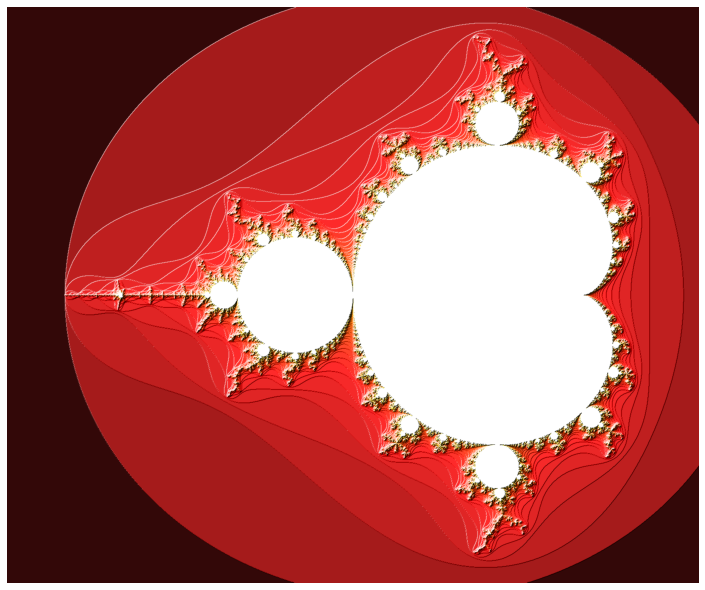

In [32]:
np = Python.import_module("numpy")
plt = Python.import_module("matplotlib.pyplot")
colors = Python.import_module("matplotlib.colors")

result = compute_mandlebrot()
dpi = 72
width = 10
height = 10 * yn // xn

fig = plt.figure(1, [width, height], dpi)
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)

light = colors.LightSource(315, 10, 0, 1, 1, 0)
image = light.shade(
        result.to_numpy(), plt.cm.hot, colors.PowerNorm(0.3), "hsv", 0, 0, 1.5
    )
plt.imshow(image)
plt.axis("off")
plt.show()

We showed a naive implementation of the Mandelbrot algorithm, but there are two things we can do to speed it up. We can early-stop the loop iteration when a pixel is known to have escaped, and we can leverage Mojo's access to hardware by vectorizing the loop, computing multiple pixels simultaneously.

In [ ]:
# Some aliases to make the code easier to read
alias ComplexSIMD = ComplexGenericSIMD[DType.f32, 8]
alias NumStepsSIMD = SIMD[DType.si64, 8]

# Multi-element mandlebrot with early-stop optimization.
def mandlebrot_kernel_simd(c: ComplexSIMD, iter: Int) -> NumStepsSIMD:
    z = c
    nv = NumStepsSIMD(0)
    done_mask = SIMD[DType.bool, 8](0)

    i = 100
    while i != 0 and done_mask:
        done_mask = z.norm() > 4 
        z = z*z + c
        nv = done_mask.select(nv, nv + 1)
        i -= 1
    return nv